# Example of apache spark for the analysis of L1-trigger scouting data

Contact: m.migliorini@cern.ch <br>

### Useful material
Description of spark resources at cern: [link](https://sparktraining.web.cern.ch/slides/Introduction_to_Spark_Session4.pdf)<br>
Spark Examples: [link](https://swan-gallery.web.cern.ch/apache_spark/)

## Configuring the Spark application

While configuring your SWAN instance, choose a spark cluster among `Analytix` and `Cloud Containers (k8s)`.<br>
Once the instance has been created, open a notebook and in the widget bar a button with a star will be available (`spark cluster connection`).<br>
Press it to configure the spark application. This will be slightly different based on the chosen cluster.


### Analytix cluster configs

Standard spark job configs, taken from [here](https://spark.apache.org/docs/latest/configuration.html). Example:

* `spark.driver.memory`: `10g`
* `spark.executor.cores`: `4`
* `spark.executor.instances`: `10`
* `spark.executor.memory`: `10g`
* ...

To access files stored on EOS the hadoop-xrootd connector is required. 
The connector can be included by adding the following options to the configs

* `spark.executor.extraClassPath`: `/cvmfs/sft.cern.ch/lcg/releases/hadoop_xrootd/1.0.7-e00b1/x86_64-centos7-gcc11-opt/lib/hadoop-xrootd.jar`
* `spark.driver.extraClassPath`: `/cvmfs/sft.cern.ch/lcg/releases/hadoop_xrootd/1.0.7-e00b1/x86_64-centos7-gcc11-opt/lib/hadoop-xrootd.jar`

and by ticking the bundle `Include ShipKerberosToExecutors options`. <br>
The Kerberos ticket can be can be created by opening a swan terminal and typing `kinit` and inseriting your password.
To open a terminal, navigate to the current swan container home page, e.g. `https://swan0XX.cern.ch/user/your_user/projects`, 
and press on the `new terminal` button in the upper right corner. This will ridirect you to `https://swan0XX.cern.ch/user/your_user/terminals/1`.
 

### k8s cluster

In the cloud containers cluster, data stored on EOS are accesible by defaul.
The only required configurations are number of workers, memory ecc. 


## Start connection

Press the `connect` green button and wait untill a message such as `You are connected to analytix` pops up.<br>
Now, it is possible to close the configuration page and a spark session named `spark` should be available. <br>
If the cluster is correctly configured, by running the following cell some basic information about the spark session will appear.

In [1]:
spark

## Import packages and define constants

In [2]:
import pandas as pd
import numpy as np

import pyspark.sql.functions as F
from pyspark.sql.functions import when, col

import matplotlib.pyplot as plt
import matplotlib as mpl

# install mplhep if needed, only used for plot styling
import mplhep as hep
hep.style.use(hep.style.CMS)

In [3]:
DURATION_BX = 25 # BX counter duration in ns
ORBIT_BX = 3564  # number of BX in an orbit

## Load data

It is possible to tell Spark to load all the files in a directory matching a specific pattern, in this case `scout_GMT_362653_*.pqt`.

In [4]:
dataset_path = '/eos/cms/store/cmst3/group/daql1scout/run3/funpack/362653/scout_GMT_362653_*.pqt'

In [5]:
# number of files
!ls $dataset_path | wc -l

603


In [6]:
df = (
    spark
    .read
    .parquet('root://eosuser.cern.ch/'+dataset_path)
)

In [7]:
df.printSchema()

root
 |-- orbit: long (nullable = true)
 |-- bx: integer (nullable = true)
 |-- interm: byte (nullable = true)
 |-- pt: float (nullable = true)
 |-- ptuncon: float (nullable = true)
 |-- charge: byte (nullable = true)
 |-- iso: byte (nullable = true)
 |-- index: byte (nullable = true)
 |-- qual: byte (nullable = true)
 |-- phi: float (nullable = true)
 |-- phie: float (nullable = true)
 |-- eta: float (nullable = true)
 |-- etae: float (nullable = true)
 |-- dxy: byte (nullable = true)



## NOTE

remember that Spark addopt a lazy evaluation, which means that the command is not executed untill an action triggers it (e.g. counting the number of entries)<br>
For example, in the previous instruction, the spark application went through all da files in the run directory and checked the ones matching the pattern. However, they haven't been loaded yet <br>

In [8]:
print('Number of muons in the dataset: %s'%df.count())

Number of muons in the dataset: 12598897340


Using the column `index` is is possible to associate a muon to a specific region of the muon system (`barrel`, `overlap` and `endcap`)

In [9]:
df = (
    df
    .withColumn('region', 
              when((df['index']>=36)&(df['index']<=70), 'barrel') \
              .when(((df['index']>=0)&(df['index']<=16)) | ((df['index']>=90)&(df['index']<=107)), 'endcap') \
              .when((((df['index']>=17)&(df['index']<=35)) | ((df['index']>=71)&(df['index']<=89))), 'overlap') \
              .otherwise('invalid')
             )
)

Number of muons in each region. Notice that the `groupby` operation is perfomed by the spark worker distributed on many compute nodes, only the result of the operation is returned to the driver (i.e. python application on Swan) with the command `toPandas()`.
All the "heavy lifting" should be exectuted by spark workers, only results should be returned to the driver otherwise this will cause out of memory problems.

In [10]:
regionCounts = (
    df
    .groupBy('region').count()
    .toPandas()
) 

In [11]:
regionCounts

region       count
0  overlap  2216935071
1   endcap  9641819401
2   barrel   740142868

Add a column with the time stamp, based on the orbit number

In [12]:
max_orbit, min_orbit = df.select(F.max(df['orbit']), F.min(df['orbit'])).first()

run_time = (max_orbit-min_orbit) * ORBIT_BX * DURATION_BX * 10**(-9)
print("Run lasted {:.2f} seconds".format(run_time))

Run lasted 3526.91 seconds


In [13]:
df = df.withColumn('deltaT', (df['orbit']-min_orbit)* ORBIT_BX * DURATION_BX * 10**(-9))

## Bunch occupancy

In [14]:
bxOccupancy = (
    df
    .groupBy('bx')
    .agg((F.count('bx'))
    .alias('nMuons'))
)
bxOccupancy_pd = bxOccupancy.toPandas().sort_values('bx')

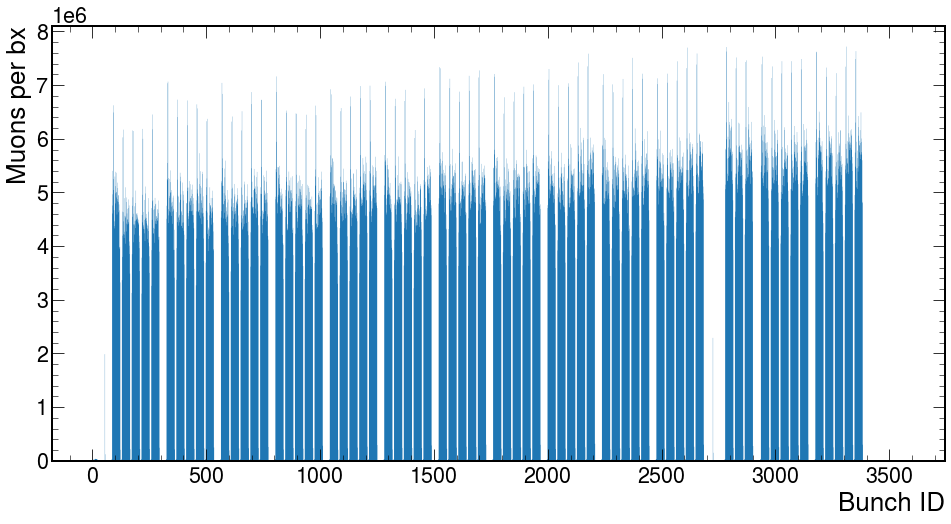

In [15]:
occBuffer = np.zeros(3564)

for idx, (bx,rate) in bxOccupancy_pd.iterrows():
    occBuffer[int(bx)-1] = rate

plt.figure(figsize=(16,8))
bins = np.arange(0,3565)
centroids = (bins[1:] + bins[:-1]) / 2
hep.histplot(occBuffer, bins, histtype="fill")

plt.xlabel("Bunch ID")
plt.ylabel("Muons per bx")

#plt.semilogy()
plt.show()

## Rate vs Time

In [16]:
# aggregate every 4096 orbits

muons_count = (
    df
    .withColumn('idx', F.floor(df['orbit']/4095))
    .groupBy('idx').agg(
        (F.count('orbit')/(F.max('deltaT')-F.min('deltaT'))).alias('muonRate'),
        (F.max('deltaT')-F.min('deltaT')).alias('interval'),
        F.min('deltaT').alias('time'),
        F.min('orbit').alias('orbit')
    )
)

In [17]:
# get results and sort them based on the timestamp
muons_count_pd = muons_count.toPandas().sort_values('time')

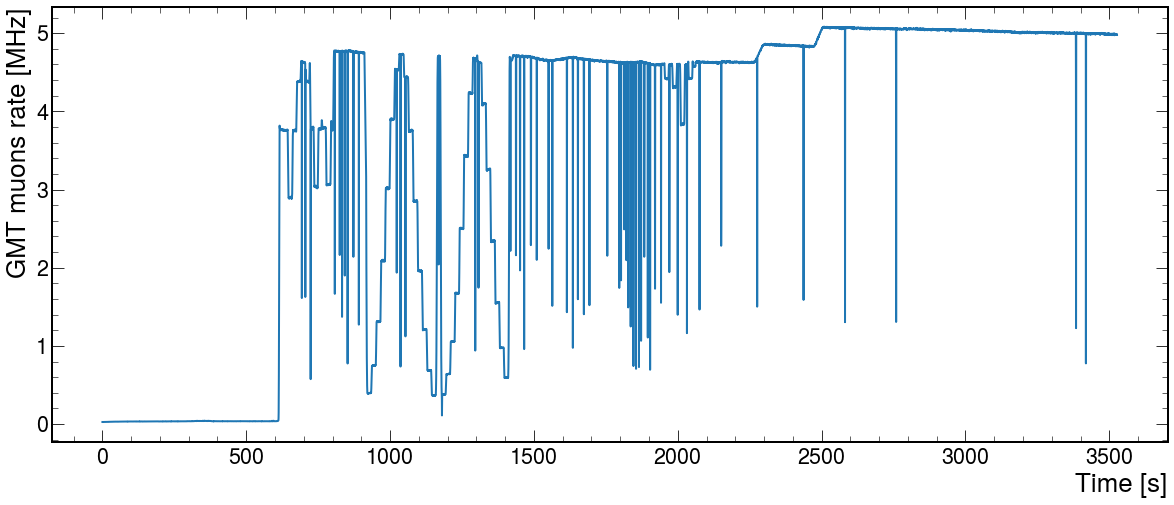

In [18]:
plt.figure(figsize=(20,8))
plt.plot(muons_count_pd['time'], muons_count_pd['muonRate']/1e6, lw=2)

plt.xlabel("Time [s]")
plt.ylabel("GMT muons rate [MHz]")
plt.show()

let's focus on one region of the endcap with many spikes and count the number of muons in each orbit

In [19]:
muons_count = (
    df
    .where(df['region']=='endcap')
    .where((df['deltaT']>1860)&(df['deltaT']<1910))
    .groupBy('orbit')
    .agg(
        (F.count('orbit')).alias('nMuons'),
        F.min('deltaT').alias('time'),
    )
)

muons_count_pd = muons_count.toPandas().sort_values('time')

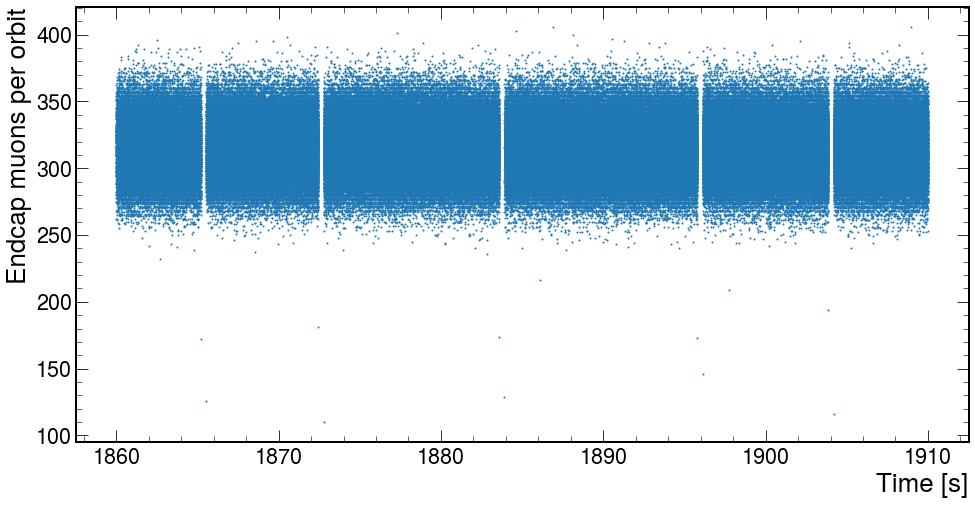

In [20]:
plt.figure(figsize=(16,8))
plt.scatter(muons_count_pd['time'], muons_count_pd['nMuons'], s=1)

plt.xlabel("Time [s]")
plt.ylabel("Endcap muons per orbit")

plt.show()

Check for gaps between two consecutive orbits

In [21]:
diff = np.diff(muons_count_pd.orbit)
muons_count_pd[:-1][diff!=1]

orbit  nMuons         time
332695  20886859     308  1861.018959
132626  20933875     172  1865.208084
358211  20973043     352  1868.697953
266056  20988570     314  1870.081409
326625  21015120     181  1872.447014
219599  21140123     174  1883.584781
504299  21206252     307  1889.476875
233562  21277152     173  1895.794065
309166  21325132     310  1900.069083
538198  21327017     291  1900.237037
27148   21342774     299  1901.640985
485370  21350731     297  1902.349954
383684  21361027     306  1903.267328
495880  21367732     194  1903.864743

In [22]:
diff[diff!=1]

array([   8, 3700,    7,    8, 3700, 3700,    8, 3700,    8,    8,    8,
          7,    8, 3700])

identical values can be found in other regions. 
The gap of `3700` is present only in the endcap muons, most likely caused by a [hard-reset sequence](https://twiki.cern.ch/twiki/bin/viewauth/CMS/TcdsTtcScheduling) issued to the CSC.<br>
On the other hand, the value of `8` orbits is compatible with a `resync`, and in that interval of time no muons are received from the GMT.

As a check, we can produce the same plot selecting only muons coming from the barrel

In [23]:
muons_count = (
    df
    .where(df['region']=='barrel')
    .withColumn('idx', F.floor(df['orbit']/4095))
    .groupBy('idx').agg(
        (F.count('orbit')/(F.max('deltaT')-F.min('deltaT'))).alias('muonRate'),
        (F.max('deltaT')-F.min('deltaT')).alias('interval'),
        F.min('deltaT').alias('time')
    )
)

In [24]:
# get results and sort them based on the timestamp
muons_count_pd = muons_count.toPandas().sort_values('time')

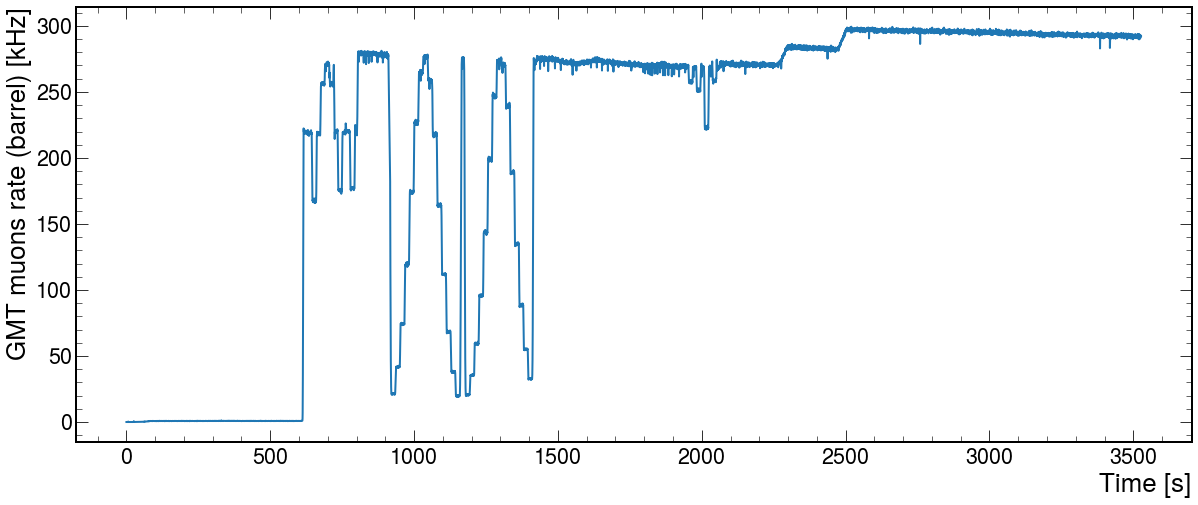

In [25]:
plt.figure(figsize=(20,8))
plt.plot(muons_count_pd['time'], muons_count_pd['muonRate']/1e3, lw=2)

plt.xlabel("Time [s]")
plt.ylabel("GMT muons rate (barrel) [kHz]")
plt.show()

In [26]:
muons_count = (
    df
    .where(df['region']=='barrel')
    .where((df['deltaT']>1860)&(df['deltaT']<1910))
    .groupBy('orbit')
    .agg(
        (F.count('orbit')).alias('nMuons'),
        F.min('deltaT').alias('time'),
    )
)

muons_count_pd = muons_count.toPandas().sort_values('time')

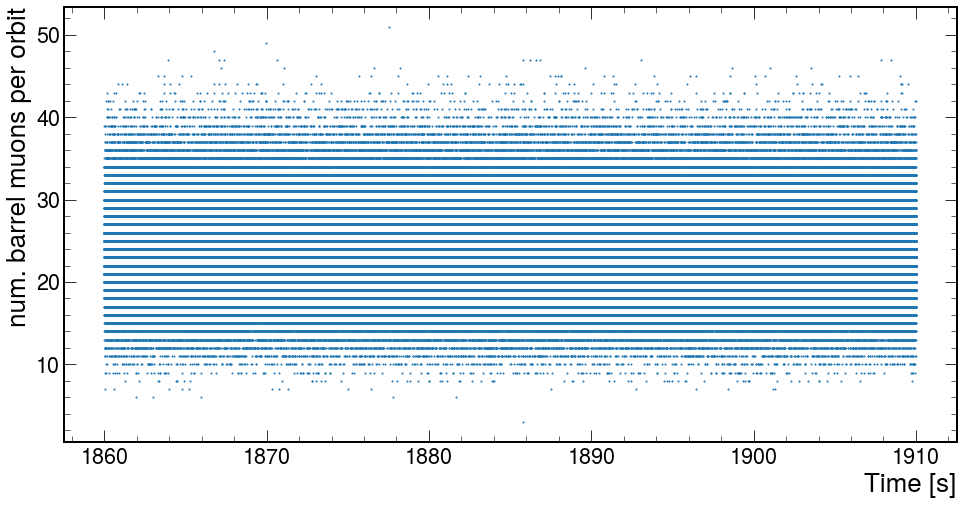

In [27]:
plt.figure(figsize=(16,8))
plt.scatter(muons_count_pd['time'], muons_count_pd['nMuons'], s=1)

plt.xlabel("Time [s]")
plt.ylabel("num. barrel muons per orbit")

plt.show()

no evident gap is present, only the known 8 orbit one

In [28]:
diff = np.diff(muons_count_pd.orbit)
diff[diff!=1]

array([8, 8, 7, 8, 8, 8, 8, 8, 7, 8])

## Filter muons

As an example, we can try to do the same plots but requiring, for example, muons in the barrel with $p_T>4$ GeV

In [29]:
muons_count = (
    df
    .where((df['region']=='barrel')&(df['pt']>4))
    .withColumn('idx', F.floor(df['orbit']/4095))
    .groupBy('idx').agg(
        (F.count('orbit')/(F.max('deltaT')-F.min('deltaT'))).alias('muonRate'),
        (F.max('deltaT')-F.min('deltaT')).alias('interval'),
        F.min('deltaT').alias('time')
    )
)

In [30]:
muons_count_pd = muons_count.toPandas().sort_values('time')

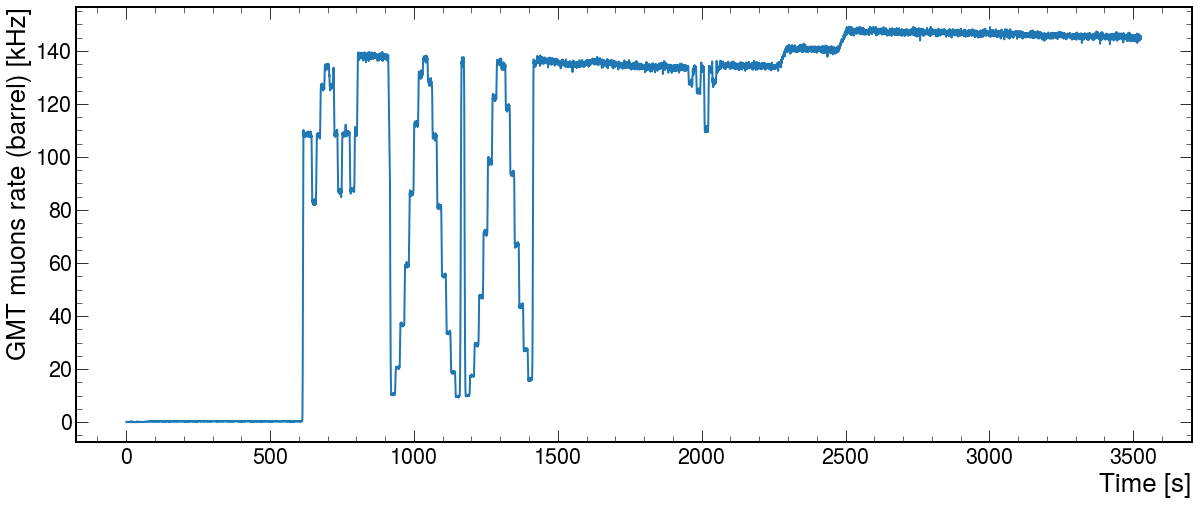

In [31]:
plt.figure(figsize=(20,8))
plt.plot(muons_count_pd['time'], muons_count_pd['muonRate']/1e3, lw=2)

plt.xlabel("Time [s]")
plt.ylabel("GMT muons rate (barrel) [kHz]")
plt.show()

Focus on the region aroud the emittance scan

In [32]:
muons_count = (
    df
    .where((df['region']=='barrel')&(df['pt']>4))
    .where((df['deltaT']>850)&(df['deltaT']<1500))
    .withColumn('idx', F.floor(df['orbit']/4095))
    .groupBy('idx').agg(
        (F.count('orbit')/(F.max('deltaT')-F.min('deltaT'))).alias('muonRate'),
        (F.max('deltaT')-F.min('deltaT')).alias('interval'),
        F.min('deltaT').alias('time')
    )
)

In [33]:
muons_count_pd = muons_count.toPandas().sort_values('time')

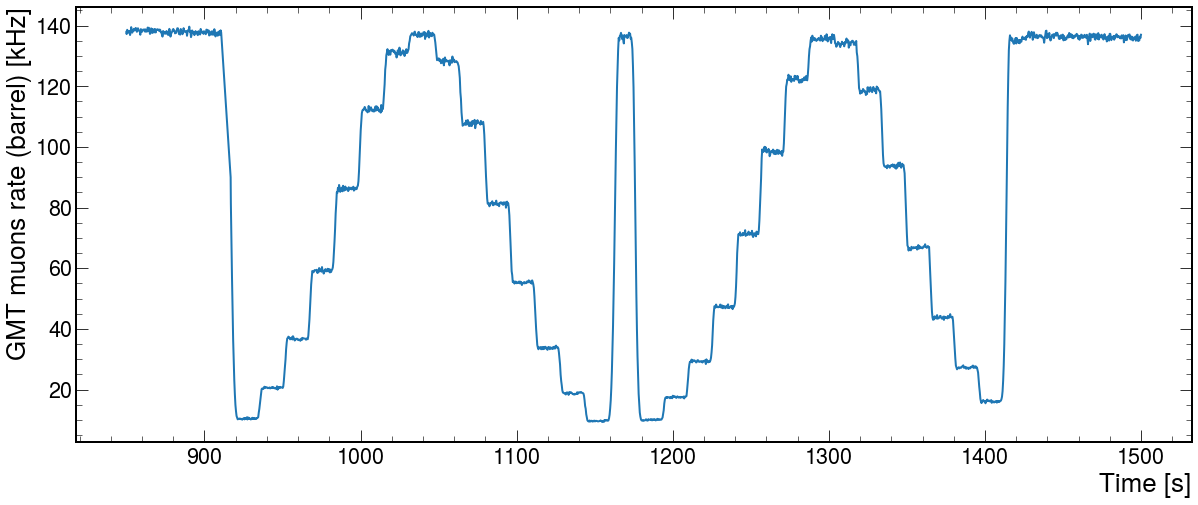

In [34]:
plt.figure(figsize=(20,8))
plt.plot(muons_count_pd['time'], muons_count_pd['muonRate']/1e3, lw=2, ms=5)

plt.xlabel("Time [s]")
plt.ylabel("GMT muons rate (barrel) [kHz]")
plt.show()